## Simplified Game Engine
- No free spaces at the edge.
- Only going to 1 sequence.

Game description: https://en.wikipedia.org/wiki/Sequence_(game)

In [54]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve2d
import torch
from scipy.special import softmax
from tqdm import tqdm
from game import *

## CNN Model

In [2]:
from torch import nn

class seq_scorer(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=(5,5), stride=1, padding='same')
        self.act1 = nn.ReLU()
        #self.drop1 = nn.Dropout(0.3)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv2 = nn.Conv2d(16, 16, kernel_size=(3,3), stride=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.flat = nn.Flatten()
        self.fc3 = nn.Linear(16, 25)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.15)
        self.fc4 = nn.Linear(25, 1)

    def forward(self,board):
        """
        Score the state to pick a move.
        Parameters
        ----------
        board: [3x10x10]
            State of the board with tokens. 'black' tokens are in the first layer, 'white' tokens are in the second layer
        """
        b = self.conv1(board)
        b = self.pool1(self.act1(b))
        b = self.conv2(b)
        b = self.pool2(self.act2(b))
        b = self.flat(b)
        o = self.fc3(b)
        o = self.act3(o)
        o = self.drop3(o)
        o = self.fc4(o)
        return o

In [3]:
model = seq_scorer()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.0002, momentum=0.9,weight_decay=0.1)
num_par = sum([l.numel() for l in model.parameters() if l.requires_grad])
print(f"There are {num_par} parameters in the model.")
print(model)

There are 3987 parameters in the model.
seq_scorer(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc3): Linear(in_features=16, out_features=25, bias=True)
  (act3): ReLU()
  (drop3): Dropout(p=0.15, inplace=False)
  (fc4): Linear(in_features=25, out_features=1, bias=True)
)


In [17]:
checkpoint = torch.load('models/cur.pth')
model.load_state_dict(checkpoint) 

<All keys matched successfully>

In [67]:
from torch import nn
class h_scorer(nn.Module):
    def __init__(self):
        super().__init__()
        self.d1 = nn.Linear(14, 1,bias=False)
    
    def forward(self,x):
        return self.d1(x)

In [68]:
model = h_scorer()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_par = sum([l.numel() for l in model.parameters() if l.requires_grad])
print(f"There are {num_par} parameters in the model.")
print(model)

There are 14 parameters in the model.
h_scorer(
  (d1): Linear(in_features=14, out_features=1, bias=False)
)


In [69]:
checkpoint = torch.load('models/Linear/lin_999.pth')
model.load_state_dict(checkpoint) 

<All keys matched successfully>

## Train Model With TD($\lambda$) Algorithm

Play full game with rewards.

In [ ]:
# Temporal Difference
import copy
from tqdm import tqdm
num_games = 5000
gamma = 0.98

loss_hist = list()

model.train()
for g in tqdm(range(num_games)):
    game = Sequence()
    game_completed = False
    batch = list()
    lab = list()
    if g % 200 == 199:
        plt.plot(loss_hist)
        plt.show()
        torch.save(model.state_dict(), f'models/Linear/lin_{g}.pth')
    while not game_completed:
        #print("T",100/(g+1)**0.5)
        move, moves = game.sample_action(model,T=10/(g+1)**0.5)
        if len(moves) == 0:
            break
        s_p = game.prepare_input(moves,move)
        game.play(moves[move],change_turn=False)
        R = game.check_winner()*10*game.turn
        if R != 0 or (game.deck_pos) < 0:
            game_completed = True
            target = R
        else:
            target = R
        batch.append(s_p)
        lab.append(torch.tensor([target],dtype=torch.float32))
        game.turn *= -1
        if R != 0:
            moves = game.get_moves()
            batch.append(game.prepare_input(moves,0))
            lab.append(torch.tensor([R*-1],dtype=torch.float32))
    optimizer.zero_grad()
    x = torch.stack(batch)
    r = torch.stack(lab)
    tot_bat = list()
    tot_lab = list()
    blue = torch.arange(0,len(x),2)
    red = torch.arange(1,len(x),2)
    b_dif = r[blue.max()]*((gamma)**(len(blue)-blue/2-1))
    r_dif = r[red.max()]*((gamma)**(len(red)-red/2-.5))
    Y = torch.cat((b_dif.unsqueeze(1),r_dif.unsqueeze(1)))
    X = torch.cat((x[blue],x[red]))
    V = model(X)
    loss = loss_fn(V, Y)
    loss_hist.append(loss.item())
    loss.backward()
    # Adjust learning weights
    optimizer.step()

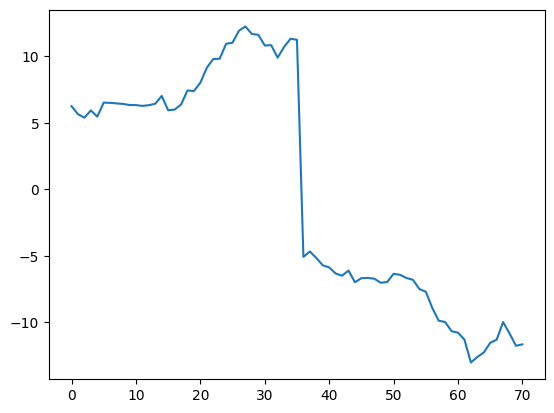

In [73]:
plt.plot(model(X).detach()-Y)

In [181]:
pars = [p for p in model.parameters()]
pars

[Parameter containing:
 tensor([[ 0.0330,  0.0846,  0.1717,  0.4427, -0.0392, -0.0716, -0.2571, -0.4096,
           0.0378,  0.0860]], requires_grad=True)]

In [74]:
pars = [p for p in model.parameters()]
pars

[Parameter containing:
 tensor([[ 0.0782,  0.1319,  0.2657,  0.5170, -0.0873, -0.1315, -0.2892, -0.5896,
          -0.0325, -0.0223,  0.0470,  0.0769, -0.0579,  0.1044]],
        requires_grad=True)]

In [15]:
torch.save(model.state_dict(), f'models/cur.pth')

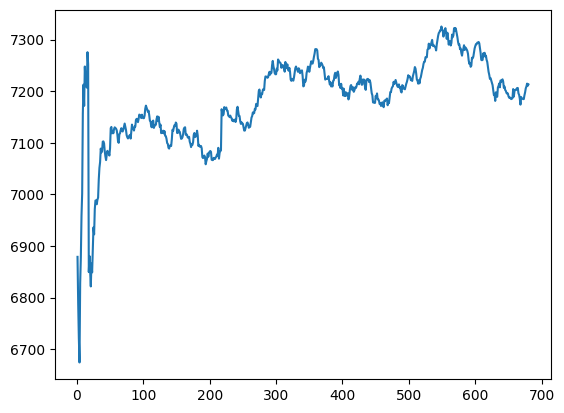

In [27]:
def moving_avg(n=5):
    avg = np.zeros(len(loss_hist))
    for i in range(len(loss_hist)):
        avg[i] = np.mean(loss_hist[max(0,i-n):i])
    return avg
plt.plot(moving_avg(n=100))
plt.show()

## Evaluate Performance Against Other Players

In [75]:
def TD_play(game,print_scores=False):
    moves = game.get_moves()
    scores = np.zeros(len(moves))
    for i in range(len(moves)):
        x = game.prepare_input(moves,i)
        scores[i] = model(x.unsqueeze(0)).item()
    if print_scores:
        print(scores)
    return moves[np.argmax(scores)]

def h_play(game):
    moves = game.get_moves()
    scores = np.zeros(len(moves))
    for i in range(len(moves)):
        scores[i] = game.try_score(moves[i])*game.turn
    return moves[np.argmax(scores)]

def r_play(game):
    moves = game.get_moves()
    return moves[np.random.choice(np.arange(len(moves)))]

def comp_players(p1,p2,show_board=False):
    game = Sequence()
    i = 0
    while game.check_winner()==0:
        if i%2 == 0:
            move = p1(game)
            game.play(move)
        else:
            move = p2(game)
            game.play(move)
        i += 1
        if show_board:
            game.show_board()
    return game.check_winner()

In [76]:
from scipy.stats import norm

#run experiment comparing
def run_exp(n,p1,p2):
    rslts = np.zeros(n)
    for i in tqdm(range(n)):
        rslts[i] = comp_players(p1,p2)
        #print(rslts[i])
    rslts = (rslts+1)/2
    n = ((rslts==1).sum()+(rslts==0).sum())
    p = (rslts==1).sum()/n
    return n,p

def eq_test(p,n):
    z = (p-.5)/(.25/n)**0.5
    return z, norm.cdf(z)

In [77]:
#power analysis
n = int(np.ceil((1.96/.1)**2*.25))
model.eval()
n,p = run_exp(n,TD_play,r_play)
z,p_val = eq_test(p,n)
p, z, p_val

100%|███████████████████████████████████████████████████████████████████████████████████| 97/97 [00:12<00:00,  8.03it/s]


(0.7282608695652174, 4.37880269519857, 0.9999940333445922)

In [78]:
n = int(np.ceil((1.96/.05)**2*.25))
model.eval()
n,p = run_exp(n,TD_play,h_play)
z,p_val = eq_test(p,n)
p, z, p_val

100%|█████████████████████████████████████████████████████████████████████████████████| 385/385 [01:15<00:00,  5.09it/s]


(0.5558912386706949, 2.0337039267384585, 0.9790092719917663)